Dataset generated: 1500. File in /Users/ivan/Desktop/AP4Fed/dataset/iv4N/data


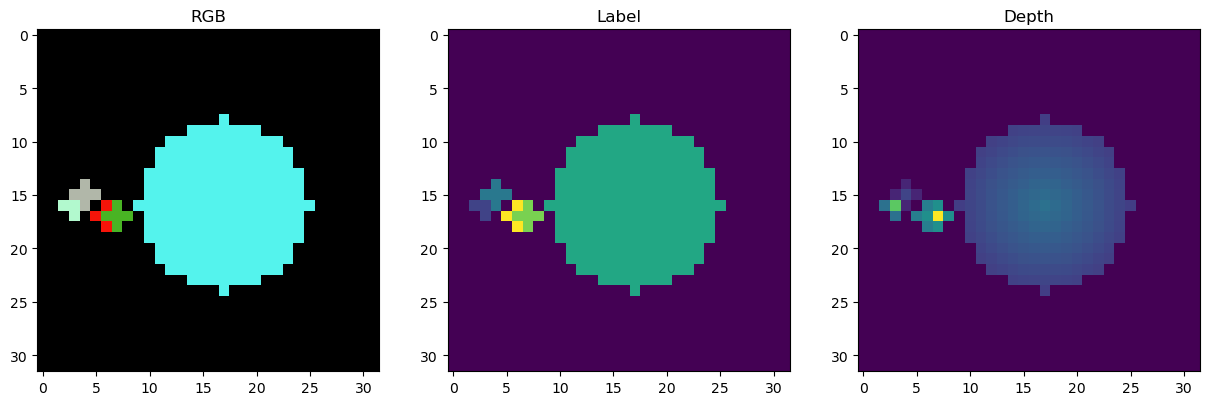

In [1]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt 

num_images = 1500
img_size = 32
num_classes = 5
fg_ratio = 0.77
alpha = 0.5

output_dirs = {
    'rgb': 'data/rgb_images',
    'depth': 'data/depth_maps',
    'label_npy': 'data/labels'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

total_fg_width = int(round(img_size * fg_ratio))
left_margin = (img_size - total_fg_width) // 2
right_margin = img_size - total_fg_width - left_margin

def random_cell_widths(num_classes, total_width, alpha):
    proportions = np.random.dirichlet([alpha] * num_classes)
    widths = (proportions * total_width).astype(int)
    diff = total_width - np.sum(widths)
    if diff != 0:
        idx = np.random.choice(num_classes)
        widths[idx] += diff
    for i in range(num_classes):
        if widths[i] < 1:
            diff = 1 - widths[i]
            widths[i] = 1
            for j in range(num_classes):
                if j != i and widths[j] > 1:
                    subtract = min(diff, widths[j] - 1)
                    widths[j] -= subtract
                    diff -= subtract
                    if diff == 0:
                        break
    return widths

def draw_large_circle_cell_rgb(img, depth_img, x_min, x_max, y_min, y_max, depth_value):
    cell_width = x_max - x_min
    cell_height = y_max - y_min
    cx = (x_min + x_max) // 2 + random.randint(-1, 1)
    cy = (y_min + y_max) // 2 + random.randint(-1, 1)
    margin = int(min(cell_width, cell_height) * 0.1)
    radius = max(1, min(cell_width, cell_height) // 2 - margin)
    color = [random.randint(0, 255) for _ in range(3)]
    
    # Create base mask
    mask = np.zeros((img_size, img_size), dtype=np.uint8)
    cv2.circle(img, (cx, cy), radius, color, -1)
    cv2.circle(mask, (cx, cy), radius, 255, -1)
    
    # Create radial depth gradient
    y, x = np.ogrid[:img_size, :img_size]
    dist_from_center = np.sqrt((x - cx)**2 + (y - cy)**2)
    # Normalize distances to [0, 1] range within the circle
    normalized_dist = np.clip(dist_from_center / radius, 0, 1)
    # Create depth gradient: higher values (brighter) at center, lower (darker) at edges
    depth_gradient = np.full_like(dist_from_center, depth_value, dtype=np.float32)
    depth_gradient[mask > 0] *= (1.0 - 0.5 * normalized_dist[mask > 0])
    depth_img[mask > 0] = depth_gradient[mask > 0].astype(np.uint8)
    
    return mask

def draw_large_rectangle_cell_rgb(img, depth_img, x_min, x_max, y_min, y_max, depth_value):
    cell_width = x_max - x_min
    cell_height = y_max - y_min
    margin_x = max(1, int(cell_width * 0.1))
    margin_y = max(1, int(cell_height * 0.1))
    pt1 = (x_min + random.randint(0, margin_x), y_min + random.randint(0, margin_y))
    pt2 = (x_max - random.randint(0, margin_x), y_max - random.randint(0, margin_y))
    color = [random.randint(0, 255) for _ in range(3)]
    
    # Create base mask and draw rectangle
    mask = np.zeros((img_size, img_size), dtype=np.uint8)
    cv2.rectangle(img, pt1, pt2, color, -1)
    cv2.rectangle(mask, pt1, pt2, 255, -1)
    
    # Create depth gradient
    rect_center_x = (pt1[0] + pt2[0]) // 2
    rect_center_y = (pt1[1] + pt2[1]) // 2
    y, x = np.ogrid[:img_size, :img_size]
    
    # Calculate normalized distances from center in both x and y directions
    max_dist_x = max(abs(pt2[0] - rect_center_x), abs(pt1[0] - rect_center_x))
    max_dist_y = max(abs(pt2[1] - rect_center_y), abs(pt1[1] - rect_center_y))
    dist_x = np.abs(x - rect_center_x) / max(max_dist_x, 1)
    dist_y = np.abs(y - rect_center_y) / max(max_dist_y, 1)
    
    # Combine distances for a 2D gradient
    normalized_dist = np.sqrt(dist_x**2 + dist_y**2) / np.sqrt(2)
    depth_gradient = np.full_like(normalized_dist, depth_value, dtype=np.float32)
    depth_gradient[mask > 0] *= (1.0 - 0.5 * normalized_dist[mask > 0])
    depth_img[mask > 0] = depth_gradient[mask > 0].astype(np.uint8)
    
    return mask

def draw_large_triangle_cell_rgb(img, depth_img, x_min, x_max, y_min, y_max, depth_value):
    cell_width = x_max - x_min
    cell_height = y_max - y_min
    margin_x = max(1, int(cell_width * 0.1))
    margin_y = max(1, int(cell_height * 0.1))
    pt1 = [x_min + random.randint(0, margin_x), y_min + random.randint(0, margin_y)]
    pt2 = [x_max - random.randint(0, margin_x), y_min + random.randint(0, margin_y)]
    pt3 = [(x_min + x_max) // 2 + random.randint(-margin_x, margin_x), y_max - random.randint(0, margin_y)]
    pts = np.array([pt1, pt2, pt3])
    color = [random.randint(0, 255) for _ in range(3)]
    
    # Create base mask and draw triangle
    mask = np.zeros((img_size, img_size), dtype=np.uint8)
    cv2.fillPoly(img, [pts], color)
    cv2.fillPoly(mask, [pts], 255)
    
    # Create depth gradient based on vertical position
    y_coords = np.arange(img_size)[:, np.newaxis]
    x_coords = np.arange(img_size)
    y_coords = np.broadcast_to(y_coords, (img_size, img_size))
    
    min_y = min(pt1[1], pt2[1], pt3[1])
    max_y = max(pt1[1], pt2[1], pt3[1])
    height_range = max_y - min_y
    if height_range == 0:
        height_range = 1
        
    normalized_height = np.clip((y_coords - min_y) / height_range, 0, 1)
    
    # Create gradient: brighter at top, darker at bottom
    depth_gradient = np.full((img_size, img_size), depth_value, dtype=np.float32)
    mask_bool = mask > 0
    depth_gradient[mask_bool] *= (1.0 - 0.4 * normalized_height[mask_bool])
    depth_img[mask_bool] = depth_gradient[mask_bool].astype(np.uint8)
    
    return mask

for i in range(num_images):
    rgb_img = np.zeros((img_size, img_size, 3), dtype=np.uint8)
    label_img = np.zeros((img_size, img_size), dtype=np.uint8)
    depth_img = np.zeros((img_size, img_size), dtype=np.uint8)
    
    cell_widths = random_cell_widths(num_classes, total_fg_width, alpha)
    x_bounds = [left_margin]
    for w in cell_widths:
        x_bounds.append(x_bounds[-1] + w)
    
    classes = list(range(1, num_classes + 1))
    random.shuffle(classes)
    
    for idx, cls in enumerate(classes):
        x_min = x_bounds[idx]
        x_max = x_bounds[idx + 1]
        y_min = 0
        y_max = img_size
        
        depth_value = random.randint(50, 255)
        shape_type = random.choice(['circle', 'rectangle', 'triangle'])
        if shape_type == 'circle':
            mask = draw_large_circle_cell_rgb(rgb_img, depth_img, x_min, x_max, y_min, y_max, depth_value)
        elif shape_type == 'rectangle':
            mask = draw_large_rectangle_cell_rgb(rgb_img, depth_img, x_min, x_max, y_min, y_max, depth_value)
        elif shape_type == 'triangle':
            mask = draw_large_triangle_cell_rgb(rgb_img, depth_img, x_min, x_max, y_min, y_max, depth_value)
        
        label_img[mask > 0] = cls
    
    rgb_filename = os.path.join(output_dirs['rgb'], f"rgb_{i}.png")
    depth_filename = os.path.join(output_dirs['depth'], f"depth_{i}.png")
    cv2.imwrite(rgb_filename, rgb_img)
    cv2.imwrite(depth_filename, depth_img)
    
    npy_filename = os.path.join(output_dirs['label_npy'], f"label_{i}.npy")
    np.save(npy_filename, label_img)

print(f"Dataset generated: {num_images}. File in {os.path.abspath('data')}")
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)), plt.title('RGB')
plt.subplot(132), plt.imshow(label_img), plt.title('Label')
plt.subplot(133), plt.imshow(depth_img, cmap='viridis'), plt.title('Depth')
plt.savefig('iv4N.png', bbox_inches='tight')
plt.show()